<a href="https://colab.research.google.com/github/cds-swinburne/Synergistic-Eigenanalysis-Covariance-Hessian/blob/main/Combined_power_on_Pima_Indians_Diabetes_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Combined Power of Hessian and Covariance Matrices Eigenanalysis for Binary Classification on <font color=#FF5F1F>the Pima Indians Diabetes dataset</font>


Covariance and Hessian matrices have been analyzed separately in the
literature for classification problems. However, integrating these matrices
has the potential to enhance their combined power in improving classification
performance. In this work, we present a novel approach that combines
the eigenanalysis of a covariance matrix evaluated on a training set with
a Hessian matrix evaluated on a deep learning model to achieve optimal
class separability in binary classification tasks. Our approach is formally
proven to approximately minimize within-class variances and maximize
between-class mean distance. By projecting data into the combined space
of the most relevant eigendirections from both matrices, we achieve optimal
class separability as per the LDA criterion. Empirical experiments
using <b><font color=#FF5F1F> the Pima Indians Diabetes data </font></b> confirm the effectiveness of our approach,
which outperforms UMAP in terms of generalization and LDA in terms of
dimensionality. The fact that the Hessian is computed
from a deep-learning model suggests that our approach can shed light on
the underlying mechanisms of black-box models. Our approach offers an
alternative tool for interpreting binary classifiers that can potentially be
extended to multi-class problems.


In [ ]:
# Import 3rd party dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from imblearn.over_sampling import SMOTE
from torch.autograd.functional import hessian
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score,
    confusion_matrix,
)
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
!pip install umap-learn
import umap.umap_ as umap
!pip install pyDML
from dml import KDA
!pip install lolP
from lol import LOL
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
from IPython.display import display, HTML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 953.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=aef11694b0fefe4a9ee8ddae008ab36d77979e396cd7783f6e47a9c1c9b2497d
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=06e6a33bc8caceea64b76dbef8127dbe77cb808277cfa7722fcc964e47aaf06e
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyDML: filename=pyDML-0.1.0-cp310-cp310-li

In [ ]:
# Suppressing Warnings and Adjusting Display Width
# We ignore any warning messages that might arise during execution to maintain clean output.
# Additionally, we adjust the display width to ensure that the content is fully visible within the Jupyter notebook.

warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load the data, exploratory data analysis, and data splitting

In this demo we will use a preprocessed version of [Pima Indians Diabetes dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database).

In [ ]:
# Load the data
!wget -O "pima_(preprocessed).csv" "https://drive.google.com/uc?export=download&id=1pW8iLL-9U1VY2j1GKx3A7rWEIE5zqATo"
dataset_df = pd.read_csv("pima_(preprocessed).csv")

--2023-11-16 16:00:57--  https://drive.google.com/uc?export=download&id=1pW8iLL-9U1VY2j1GKx3A7rWEIE5zqATo
Resolving drive.google.com (drive.google.com)... 172.253.119.113, 172.253.119.139, 172.253.119.100, ...
Connecting to drive.google.com (drive.google.com)|172.253.119.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kaklgv9amj44hir6e4oi0ce7i8eq6gjb/1700150400000/00672545188986181853/*/1pW8iLL-9U1VY2j1GKx3A7rWEIE5zqATo?e=download&uuid=422d2989-7a24-4624-9aee-80c759cc0d10 [following]
--2023-11-16 16:01:00--  https://doc-10-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kaklgv9amj44hir6e4oi0ce7i8eq6gjb/1700150400000/00672545188986181853/*/1pW8iLL-9U1VY2j1GKx3A7rWEIE5zqATo?e=download&uuid=422d2989-7a24-4624-9aee-80c759cc0d10
Resolving doc-10-0o-docs.googleusercontent.com (doc-10-0o-docs.googleusercontent.com)... 142.250.128.132, 

In [ ]:
# Print the data table
dataset_df

,N1,N2,N3,N4,N5,N6,N7,N9,N10,N11,...,Insulin,BMI,DiabetesPedigreeFunction,Age,N0,N8,N13,N12,N14,Outcome
0,0,0,0,0,0,0,0,1,1,0,...,0.311604,0.169483,0.468492,1.425995,0.436284,0.144246,-0.561641,1.202461,-0.023905,1
1,0,1,0,1,0,0,1,1,1,1,...,-0.440843,-0.848549,-0.365061,-0.190672,-0.455696,-0.929227,-0.538026,-0.382029,0.014204,0
2,0,1,0,0,0,0,0,1,1,0,...,0.311604,-1.328478,0.604397,-0.105584,-0.512575,1.734723,-0.421674,0.440289,-0.566853,1
3,1,1,1,1,0,0,1,1,1,1,...,-0.536303,-0.630399,-0.920763,-1.041549,-0.731491,-0.741294,0.583847,-0.952845,-0.389882,0
4,0,0,0,0,0,0,0,1,1,0,...,0.294758,1.551096,5.484909,-0.020496,1.169312,-1.323886,-1.241345,4.620388,-0.527802,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,0,0,1,0,0,0,1,1,0,...,0.429525,0.067679,-0.908682,2.532136,1.325177,0.618088,0.806506,-0.390389,0.257372,0
764,0,0,1,0,0,0,0,1,1,1,...,-0.440843,0.634868,-0.398282,-0.531023,0.034165,-0.417632,-0.087923,-0.513702,-0.185318,0
765,0,1,1,0,0,0,0,1,1,0,...,-0.334153,-0.906722,-0.685193,-0.275760,-0.827832,0.715187,0.433155,-0.655361,-0.162605,0
766,0,0,0,0,0,0,0,1,1,1,...,0.311604,-0.339533,-0.371101,1.170732,-0.032855,-1.063579,-0.079404,0.045425,-0.114396,1


In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   N1                        768 non-null    int64  
 1   N2                        768 non-null    int64  
 2   N3                        768 non-null    int64  
 3   N4                        768 non-null    int64  
 4   N5                        768 non-null    int64  
 5   N6                        768 non-null    int64  
 6   N7                        768 non-null    int64  
 7   N9                        768 non-null    int64  
 8   N10                       768 non-null    int64  
 9   N11                       768 non-null    int64  
 10  N15                       768 non-null    int64  
 11  Pregnancies               768 non-null    float64
 12  Glucose                   768 non-null    float64
 13  BloodPressure             768 non-null    float64
 14  SkinThickn

In [ ]:
# Generate descriptive statistics for the dataset

dataset_df.describe()

,N1,N2,N3,N4,N5,N6,N7,N9,N10,N11,...,Insulin,BMI,DiabetesPedigreeFunction,Age,N0,N8,N13,N12,N14,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,...,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,768.000000
mean,0.351562,0.380208,0.535156,0.295573,0.161458,0.126302,0.158854,0.884115,0.733073,0.407552,...,1.156482e-18,1.156482e-16,2.451743e-16,1.885066e-16,3.515706e-16,2.359224e-16,2.775558e-17,1.549686e-16,-1.191177e-16,0.348958
std,0.477769,0.485754,0.499088,0.456597,0.368193,0.332406,0.365778,0.320296,0.442642,0.491699,...,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.434747e+00,-2.070186e+00,-1.189553e+00,-1.041549e+00,-1.853851e+00,-1.323886e+00,-1.286155e+00,-1.097523e+00,-1.359163e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,-4.408430e-01,-7.176590e-01,-6.889685e-01,-7.862862e-01,-6.912022e-01,-8.141179e-01,-7.469498e-01,-6.617474e-01,-5.418435e-01,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,-4.408430e-01,-5.593870e-02,-3.001282e-01,-3.608474e-01,-1.199361e-01,-1.587017e-01,-2.883644e-01,-3.408087e-01,-2.350516e-01,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,3.116039e-01,6.057816e-01,4.662269e-01,6.602056e-01,4.952015e-01,7.151866e-01,4.793703e-01,2.746335e-01,3.134879e-01,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,7.909072e+00,5.041489e+00,5.883565e+00,4.063716e+00,6.093720e+00,3.183538e+00,6.112688e+00,5.133843e+00,7.763835e+00,1.000000


In [ ]:
# Create a column index map for predictor attributes
# The predictor_columns list contains all column names except for the "Outcome" column,
# which corresponds to the target variable. We create a column_index_map dictionary
# to associate each predictor attribute with its corresponding index (column number).
# This mapping will be useful for further data manipulation and model building.

predictor_columns = [col for col in dataset_df.columns if col != "Outcome"]
column_index_map = {}
for i, col_name in enumerate(predictor_columns):
    column_index_map[i] = col_name

In [ ]:
# Split dataset into training and test sets
train_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42)

# Separate target variable from features
train_y = train_df["Outcome"]
train_X = train_df.drop("Outcome", axis=1)
y_test = test_df["Outcome"]
X_test = test_df.drop("Outcome", axis=1)

## Covariance matrix and its eigenanalysis

The equation for the covariance matrix:

$$\text{Cov}(\theta_1, \theta_2) = \frac{1}{n-1} \sum_{i=1}^{n} (\theta_{1i} - \bar{\theta}_1)(\theta_{2i} - \bar{\theta}_2)$$

where $ \theta_1 $ and $ \theta_2 $ are random variables, $ \theta_{1i} $ and $ \theta_{2i} $ are the corresponding observations, $ \bar{\theta}_1 $ and $ \bar{\theta}_2 $ are the sample means, and $ n $ is the number of observations. This equation calculates the covariance between two random variables $ \theta_1 $ and $ \theta_2 $ by taking the average of the product of their deviations from their respective means.

By performing eigenanalysis on the covariance matrix, we can obtain the eigenvalues and eigenvectors. The eigenvectors represent the principal directions or axes of the parameter space, while the eigenvalues correspond to the variances of the parameters along those directions. The eigenvector associated with the largest eigenvalue represents the leading parameter direction with the highest variance.

In [ ]:
# Calculating the covariance matrix
covariance_matrix = train_X.cov()

#### <font color=#FF5F1F><b>Figure A</b></font>

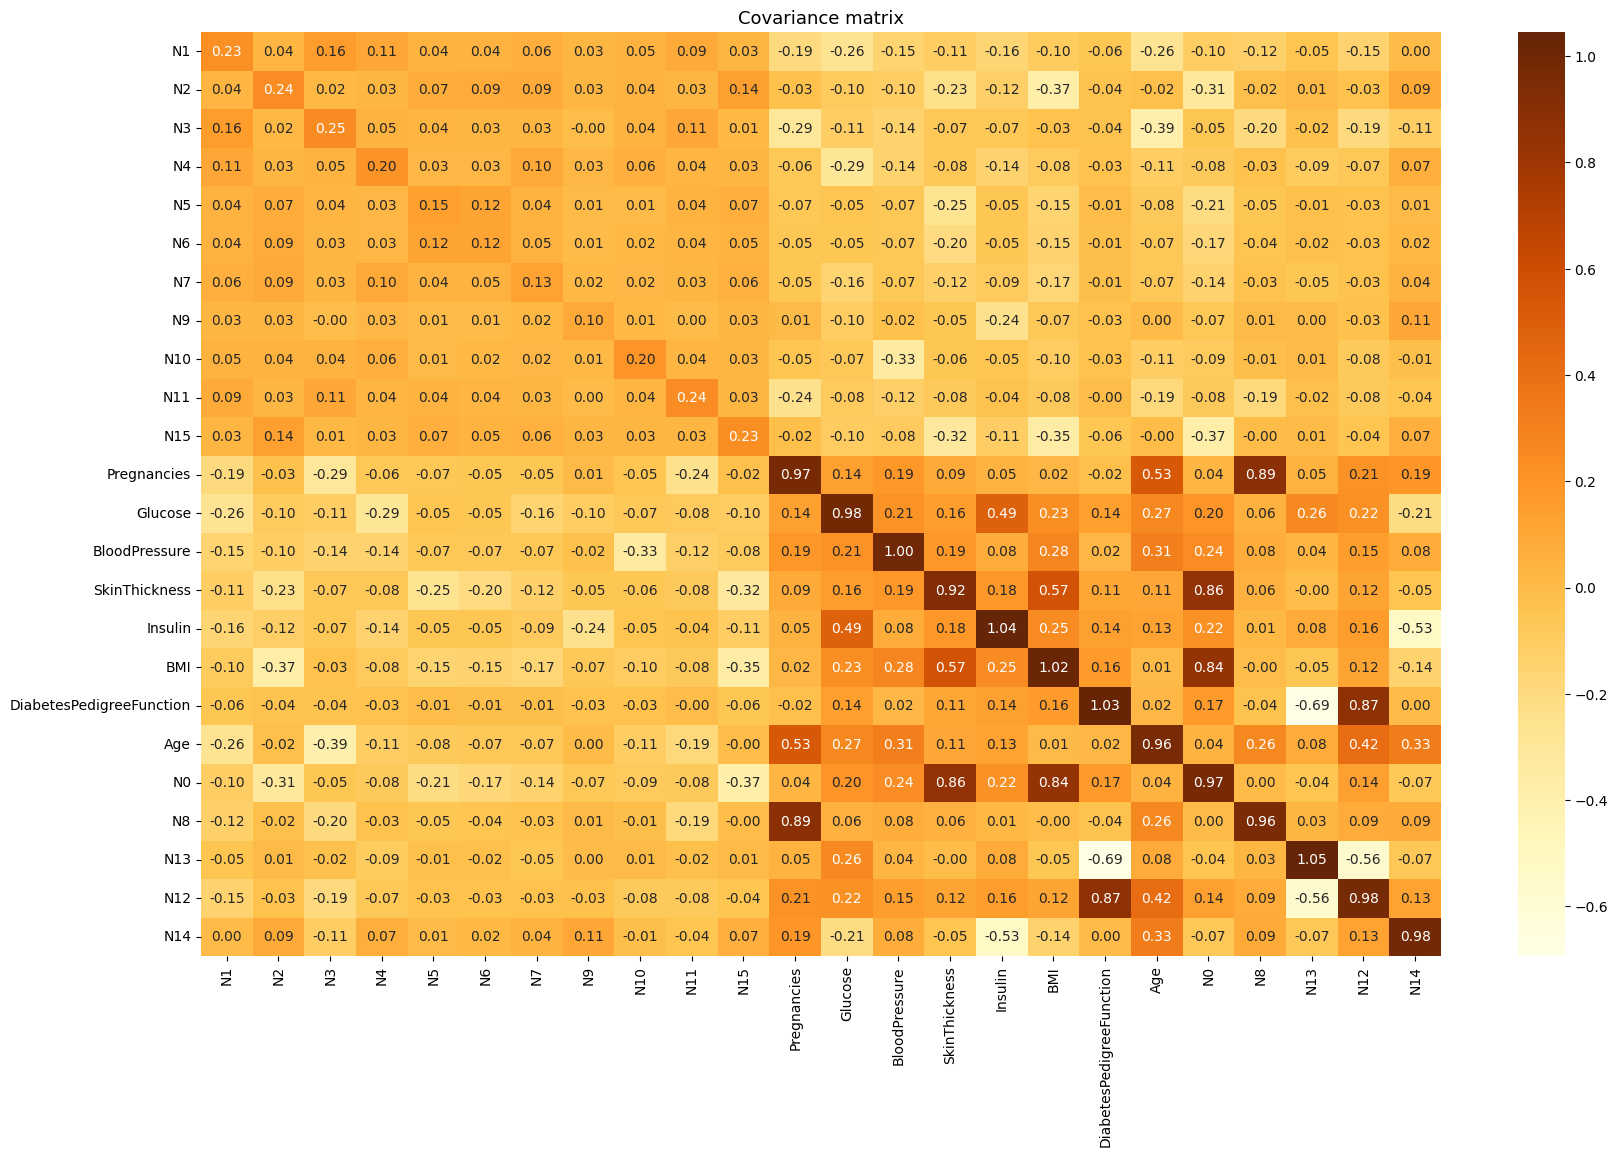

In [ ]:
# Visualize the covariance matrix as a heatmap
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20, 12))
sns.heatmap(covariance_matrix, annot=True, cmap='YlOrBr', fmt='.2f')
plt.title('Covariance matrix', fontsize=13)
plt.show()


In [ ]:
# Perform eigenanalysis on the covariance matrix
C_eigenvalues, C_eigenvectors = np.linalg.eig(covariance_matrix)

In [ ]:
# Sort covariance eigenvalues and corresponding eigenvectors in descending order
# The 'C_eigenvalues_sorted' array contains the eigenvalues sorted in descending order,
# while the 'C_eigenvectors_sorted' array contains the corresponding eigenvectors with the same sorting.

sorted_indices = np.argsort(C_eigenvalues)[::-1]
C_eigenvalues_sorted = C_eigenvalues[sorted_indices]
C_eigenvectors_sorted = C_eigenvectors[:, sorted_indices]

## Hessian matrix and its eigenanalysis

Our Hessian matrix is evaluated on a deep learning model trained on the same training set. The expected Hessian matrix is given by:

$$\mathrm{H}_\theta = - \frac{1}{n} \sum_{i=1}^n \left[\nabla_\theta^2 \log p_\theta(c_i \mid x_i) \right]$$

The Hessian matrix provides information about the curvature and landscape of the loss function with respect to the model parameters. Eigenanalysis of the Hessian matrix allows us to extract the most discriminative directions that separate different classes.

### Deep learning model training and evaluation

We employ a deep neural network architecture consisting of four fully connected layers, each followed by a Rectified Linear Unit (ReLU) activation. The final layer employs a sigmoid activation function to yield a probability value within the range of 0 to 1. During training, we utilize the binary cross-entropy loss function along with the Adam optimizer. Addressing the class imbalance issue, we resample the training dataset using the RandomOverSampler technique.

In [ ]:
# Define the neural network model
class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


# Create a custom dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Resample the training set using RandomOverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(train_X, train_y)


# Set the random seed
torch.manual_seed(35)

# Create data loaders for training and test sets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Instantiate the model and the optimizer
model = MyModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters())

# Train the model
num_epochs = 1000
criterion = nn.BCELoss()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

# Evaluate the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_pred_proba = model(X_test_tensor).detach().numpy()
y_pred = (y_pred_proba >= 0.5).astype(int)
auc_roc = roc_auc_score(y_test, y_pred_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("Precision:", precision)
print("F1 score:", f1score)

# Print evaluation metrics
print("AUC ROC:", auc_roc)
print("Cohen Kappa Score:", cohen_kappa)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Geometric Mean Score:", gmean)

Confusion Matrix:
[[84 15]
 [13 42]]
Precision: 0.7368421052631579
Recall: 0.7636363636363637
Precision: 0.7368421052631579
F1 score: 0.7499999999999999
AUC ROC: 0.8804407713498622
Cohen Kappa Score: 0.6072144288577155
Accuracy: 0.8181818181818182
Geometric Mean Score: 0.8049434044064966


In [ ]:
# Set the model to evaluation mode
model.eval()

# Compute the average Hessian matrix
hessian_sum = None
for i in range(len(train_X)):
    x = torch.tensor(train_X.iloc[i].values, dtype=torch.float32)
    y = torch.tensor([train_y.iloc[i]], dtype=torch.float32)

    hessian_matrix = hessian(lambda inputs: criterion(model(inputs), y), x)

    if hessian_sum is None:
        hessian_sum = hessian_matrix
    else:
        hessian_sum += hessian_matrix

hessian_matrix_avg = hessian_sum / len(train_X)

#### <font color=#FF5F1F><b>Figure B</b></font>

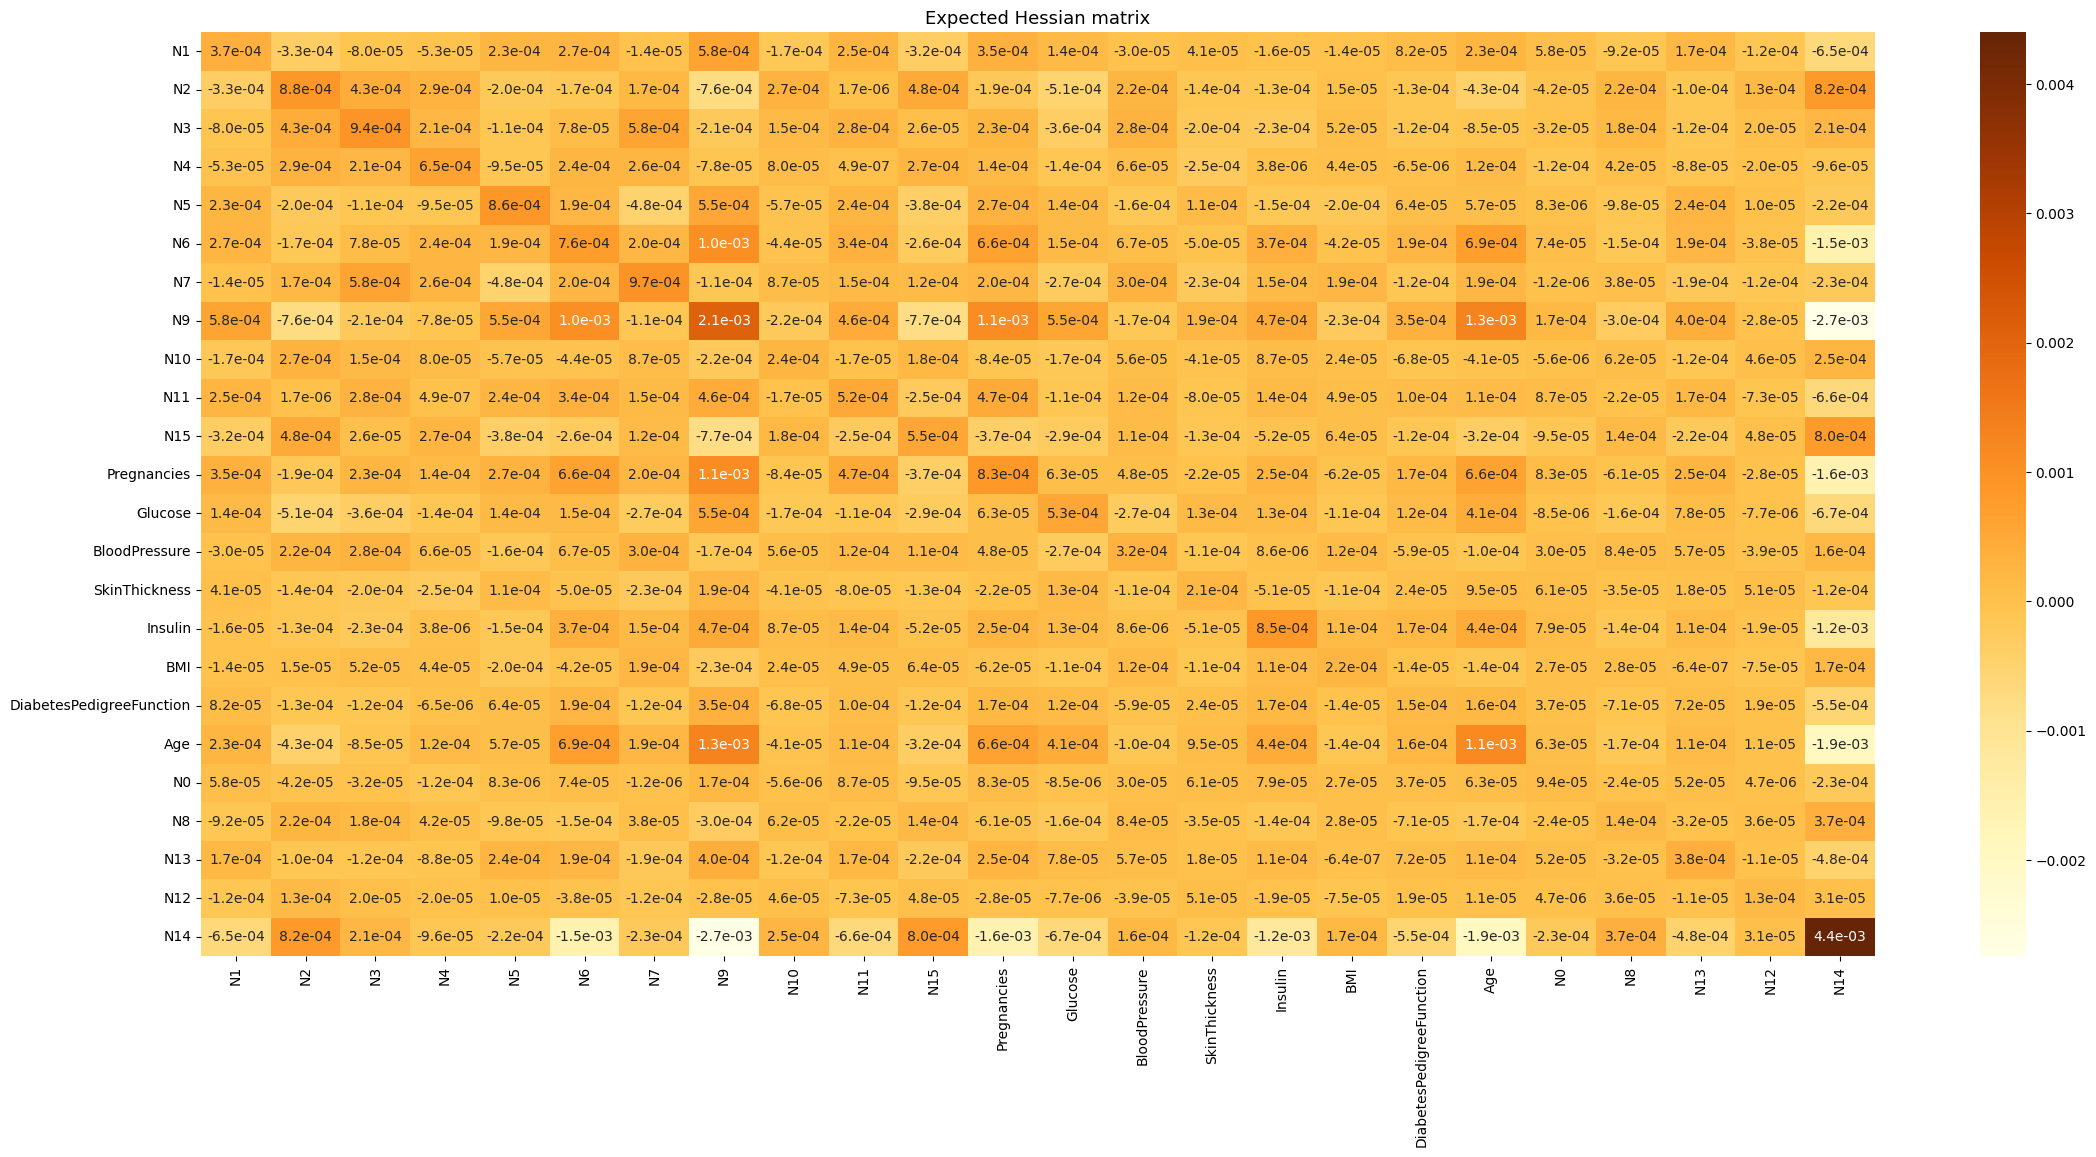

In [ ]:
# Visualize the Hessian matrix as a heatmap
plt.figure(figsize=(27, 12))
ax = sns.heatmap(hessian_matrix_avg, annot=True, cmap="YlOrBr", fmt='.1e')

# Set x-axis and y-axis tick labels using column_index_map
attribute_names = [column_index_map[i] for i in range(len(column_index_map))]
ax.set_xticklabels(attribute_names, rotation=90)
ax.set_yticklabels(attribute_names, rotation=0)

plt.title('Expected Hessian matrix', fontsize=13)
plt.show()



In [ ]:
# Perform eigenanalysis on the Hessian matrix

H = hessian_matrix_avg.numpy()
H_eigenvalues, H_eigenvectors = np.linalg.eig(H)
H_eigenvectors = np.real(H_eigenvectors)

In [ ]:
# Sort Hessian eigenvalues and corresponding eigenvectors in descending order
# The 'H_eigenvalues_sorted' array contains the Hessian eigenvalues sorted in descending order,
# while the 'H_eigenvectors_sorted' array contains the corresponding Hessian eigenvectors with the same sorting.

sorted_indices = np.argsort(H_eigenvalues)[::-1]
H_eigenvalues_sorted = H_eigenvalues[sorted_indices]
H_eigenvectors_sorted = H_eigenvectors[:, sorted_indices]

### The contribution of the parameters to the first Hessian eigenvector

The horizontal bar plot will illustrate the relative importance of each parameter in influencing the first eigenvector of the Hessian matrix. Parameters with higher contributions have a greater impact on the first eigenvector and play a crucial role in distinguishing different classes within the dataset.

#### <font color=#FF5F1F><b>Figure C</b></font>

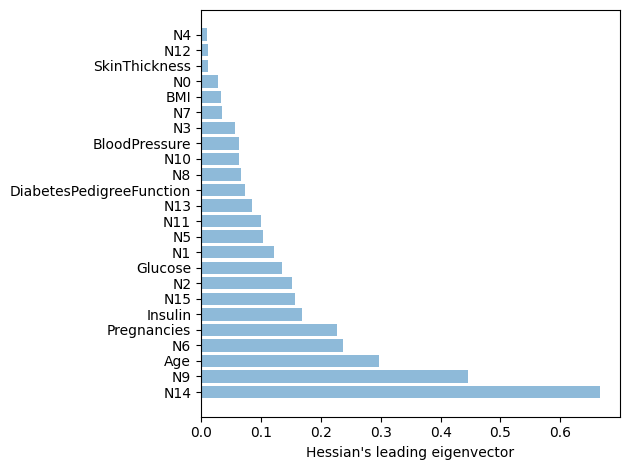

In [ ]:
# Calculate the absolute values of the elements in the first eigenvector of the Hessian matrix
H_first_eigenvector = abs(H_eigenvectors_sorted[:, 0])

# Define parameter names
param_names = [column_index_map[i] for i in range(24)]


# Sort the parameters by their absolute contributions
sorted_indices = np.argsort(np.abs(H_first_eigenvector))[::-1]
sorted_param_names = [param_names[i] for i in sorted_indices]
sorted_contributions = H_first_eigenvector[sorted_indices]

# Create a horizontal bar plot
y_pos = np.arange(len(sorted_param_names))
plt.barh(y_pos, sorted_contributions, align="center", alpha=0.5)
plt.yticks(y_pos, sorted_param_names)
plt.xlabel("Hessian's leading eigenvector")

# Display the plot
plt.tight_layout()
plt.show()

## Projection of data using Hessian and covariance eigenvectors

We project data into the combined space of eigendirections from the covariance and Hessian matrices.

### Selected 9 out of 576 projected data plots, each representing the combined space of Hessian and covariance eigenvectors

#### <font color=#FF5F1F><b>Figure D</b></font>

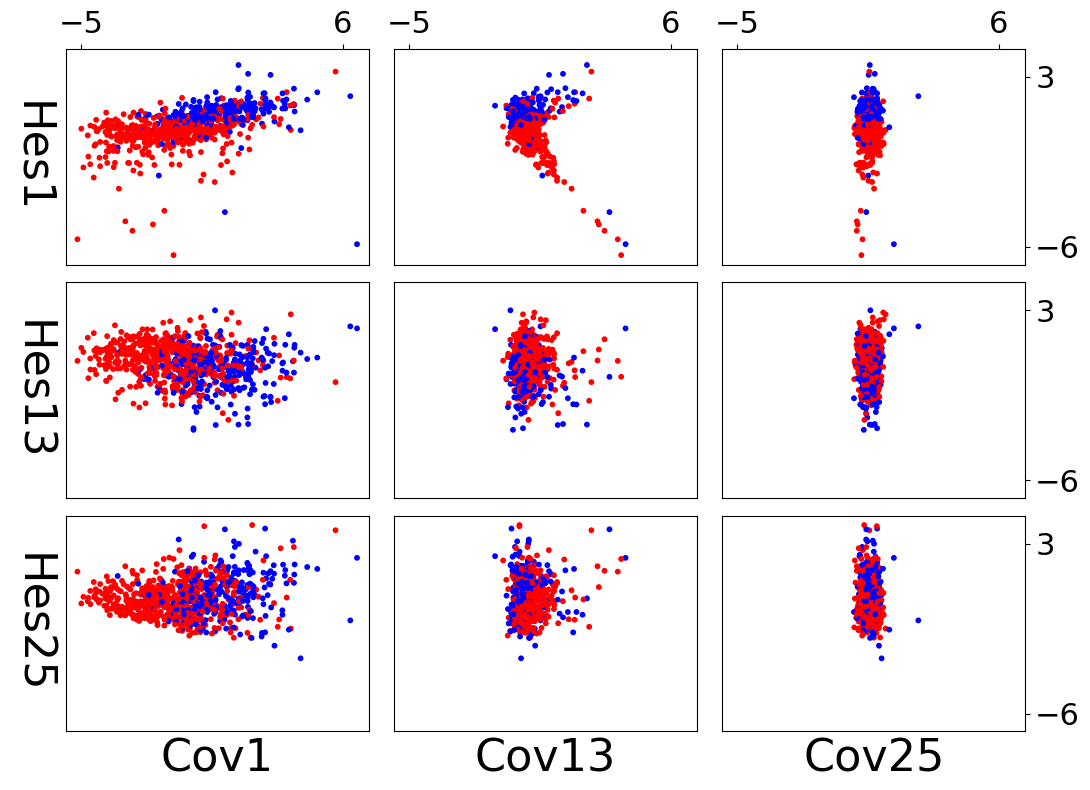

In [ ]:
# Compute 30-dimensional projections using H_eigenvectors_sorted
H_proj = np.dot(dataset_df.drop("Outcome", axis=1), H_eigenvectors_sorted[:, :24])
H_proj = H_proj / H_proj.std(axis=0)

# Compute 30-dimensional projections using C_eigenvectors_sorted
C_proj = np.dot(dataset_df.drop("Outcome", axis=1), C_eigenvectors_sorted[:, :24])

# Define colors based on class values in train_y
colors = ["red" if y == 0 else "blue" for y in dataset_df["Outcome"]]

# Select eigenvectors for projection
H_proj_selected = [
      H_proj[:, 0]/ np.std(H_proj[:, 0]),
      H_proj[:, 8]/ np.std(H_proj[:, 8]),
      H_proj[:, 16]/ np.std(H_proj[:, 16]),
]
C_proj_selected = [
    C_proj[:, 0],
    C_proj[:, 8],
    C_proj[:, 16],
]

x_low_limit = min([min(C_proj[:, 0]), min(C_proj[:, 8]), min(C_proj[:, 16])])
x_up_limit = max([max(C_proj[:, 0]), max(C_proj[:, 8]), max(C_proj[:, 16])])

y_low_limit = min([min(H_proj[:, 0]), min(H_proj[:, 8]), min(H_proj[:, 16])])
y_up_limit = max([max(H_proj[:, 0]), max(H_proj[:, 8]), max(H_proj[:, 16])])

# Compute and visualize all 9 projections
fig, axs = plt.subplots(3, 3, figsize=(11, 8))

results = []
for i in range(3):
    for j in range(3):
        # Compute the 2-dimensional projection using the current eigenvectors
        X_proj = np.stack((H_proj_selected[i], C_proj_selected[j]), axis=1)

        # Compute the mean of each class
        mean0 = np.mean(C_proj_selected[j][dataset_df["Outcome"] == 0], axis=0)
        mean1 = np.mean(C_proj_selected[j][dataset_df["Outcome"] == 1], axis=0)

        m0 = np.mean(H_proj_selected[i][dataset_df["Outcome"] == 0], axis=0)
        m1 = np.mean(H_proj_selected[i][dataset_df["Outcome"] == 1], axis=0)

        # Compute the squared distance of inter-class means
        d2 = np.sum(np.square(mean0 - mean1))

        # Compute the variance of class 0
        var0 = np.sum(np.square(H_proj_selected[i][dataset_df["Outcome"] == 0] - m0)) / (
            H_proj_selected[i][dataset_df["Outcome"] == 0].shape[0] - 1
        )

        # Compute the variance of class 1
        var1 = np.sum(np.square(H_proj_selected[i][dataset_df["Outcome"] == 1] - m1)) / (
            H_proj_selected[i][dataset_df["Outcome"] == 1].shape[0] - 1
        )

        # Plot the projection on the corresponding subplot
        axs[i, j].scatter(C_proj_selected[j], H_proj_selected[i], c=colors, s=10)

        # Set the same x-axis limits for all subplots
        axs[i, j].set_xlim([x_low_limit-0.5, x_up_limit+0.5])

        # Set the same y-axis limits for all subplots
        axs[i, j].set_ylim([y_low_limit-0.5, y_up_limit+0.5])

        if i > 0:
            axs[i, j].set_xticks([])
        else:
            axs[i, j].xaxis.tick_top()
            axs[i, j].set_xticks([int(x_low_limit), int(x_up_limit)])

        if j < 2:
            axs[i, j].set_yticks([])
        else:
            axs[i, j].yaxis.tick_right()
            axs[i, j].set_yticks([int(y_low_limit), int(y_up_limit)])

        # Increase the font size of ticks
        axs[i, j].tick_params(axis='both', which='both', labelsize=22)

        # Add labels for each column
        axs[2, j].set_xlabel(f"Cov{12*j+1}", fontsize=32, position=(0.5, -0.15))
        axs[i, 0].set_ylabel(f"Hes{12*i+1}", fontsize=32, rotation=270, labelpad=40)

        # Store the computed values
        results.append({"projection": (i, j), "d2": d2, "var0": var0, "var1": var1})


plt.tight_layout()
plt.show()

### Selected 25 out of 576 projected data plots, each representing the combined space of Hessian and covariance eigenvectors

#### <font color=#FF5F1F><b>Figure E</b></font>

In [ ]:
# Select eigenvectors for projection
H_proj_selected = [
      H_proj[:, 0]/ np.std(H_proj[:, 0]),
      H_proj[:, 4]/ np.std(H_proj[:, 4]),
      H_proj[:, 8]/ np.std(H_proj[:, 8]),
      H_proj[:, 12]/ np.std(H_proj[:, 12]),
      H_proj[:, 16]/ np.std(H_proj[:, 16]),
  ]
C_proj_selected = [
    C_proj[:, 0],
    C_proj[:, 4],
    C_proj[:, 8],
    C_proj[:, 12],
    C_proj[:, 16],
]

# Compute all 25 projections

results = []
for i in range(5):
    for j in range(5):
        # Compute the 2-dimensional projection using the current eigenvectors
        X_proj = np.stack((H_proj_selected[i], C_proj_selected[j]), axis=1)

        # Compute the mean of each class
        mean0 = np.mean(C_proj_selected[j][dataset_df["Outcome"] == 0], axis=0)
        mean1 = np.mean(C_proj_selected[j][dataset_df["Outcome"] == 1], axis=0)

        m0 = np.mean(H_proj_selected[i][dataset_df["Outcome"] == 0], axis=0)
        m1 = np.mean(H_proj_selected[i][dataset_df["Outcome"] == 1], axis=0)

        # Compute the squared distance of inter-class means
        d2 = np.sum(np.square(mean0 - mean1))

        # Compute the variance of class 0
        var0 = np.sum(np.square(H_proj_selected[i][dataset_df["Outcome"] == 0] - m0)) / (
            H_proj_selected[i][dataset_df["Outcome"] == 0].shape[0] - 1
        )

        # Compute the variance of class 1
        var1 = np.sum(np.square(H_proj_selected[i][dataset_df["Outcome"] == 1] - m1)) / (
            H_proj_selected[i][dataset_df["Outcome"] == 1].shape[0] - 1
        )

        # Store the computed values
        results.append({"projection": (i, j), "d2": d2, "var0": var0, "var1": var1})

### Heatmap showing the squared between-class mean distance across different covariance eigenvectors for varying combinations of Hessian and covariance eigenvectors

#### <font color=#FF5F1F><b>Figure F</b></font>

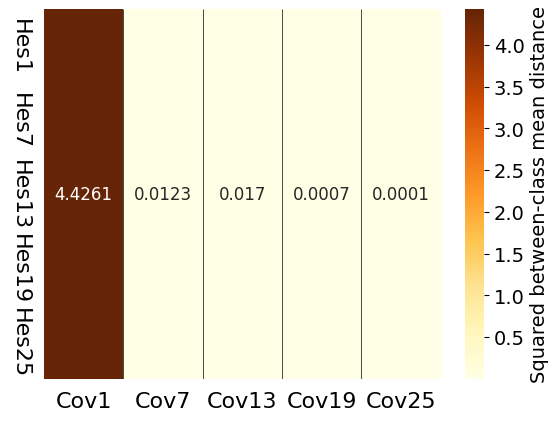

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

d2_matrix = np.array([result["d2"] for result in results]).reshape(5, 5)

plt.rcParams.update({'font.size': 14})

# Create a heatmap of the d2 matrix using seaborn
annot = np.full_like(d2_matrix, "", dtype=np.object)
annot[2, :] = np.round(d2_matrix[2, :], decimals=4).astype(str)
ax = sns.heatmap(d2_matrix, annot=annot, fmt="", cmap="YlOrBr", cbar=True,
                 annot_kws={"fontsize": 12})  # Set the desired font size

ax.set_xticks([])
ax.set_yticks([])
ax.vlines(np.arange(1, 5), *ax.get_ylim(), colors='black', linewidth=0.5)

for i in range(5):
    ax.text(i + 0.5, 5.3, f"Cov{i*6+1}", ha="center", va="center", fontsize=16)  # Set font size
for j in range(5):
    ax.text(-0.3, j + 0.5, f"Hes{j*6+1}", ha="center", va="center", rotation=270, fontsize=16)  # Set font size

# Show the color bar
cbar = ax.collections[0].colorbar
cbar.set_label("Squared between-class mean distance")
plt.show()

### Heatmap showing the sum of within-class variances across different Hessian eigenvectors and for different combinations of Hessian and covariance eigenvectors

#### <font color=#FF5F1F><b>Figure G</b></font>

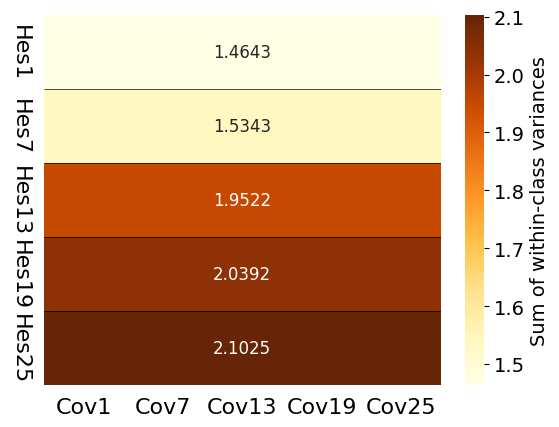

In [ ]:
var0_matrix = np.array([result["var0"] for result in results]).reshape(5, 5)
var1_matrix = np.array([result["var1"] for result in results]).reshape(5, 5)

v_matrix = var0_matrix + var1_matrix

# Create a heatmap of the d2 matrix using seaborn
ax = sns.heatmap(
    v_matrix,
    annot=np.where(
        np.arange(v_matrix.shape[0]) == 2, v_matrix.round(4).astype(str), ""
    ),
    fmt="",
    cmap="YlOrBr",
    cbar=True,
    annot_kws={"fontsize": 12}
)

ax.set_xticks([])
ax.set_yticks([])
ax.hlines(np.arange(1, 5), *ax.get_xlim(), colors='black', linewidth=0.5)

for i in range(5):
    ax.text(i + 0.5, 5.3, f"Cov{i*6+1}", ha="center", va="center", fontsize=16)  # Set font size
for j in range(5):
    ax.text(-0.3, j + 0.5, f"Hes{j*6+1}", ha="center", va="center", rotation=270, fontsize=16)  # Set font size


# Show the color bar
cbar = ax.collections[0].colorbar
cbar.set_label("Sum of within-class variances")

plt.show()

### Heatmap displaying the LDA ratio

Each value representing the ratio between the squared between-class mean distance on the covariance eigenvector projection and the corresponding within-class variances on the Hessian eigenvector projection

#### <font color=#FF5F1F><b>Figure H</b></font>

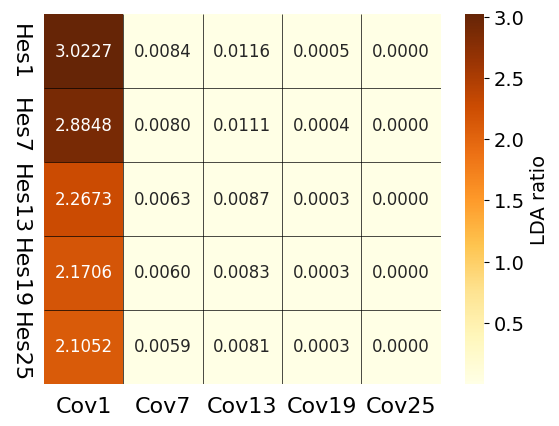

In [ ]:
c_matrix = d2_matrix / (var0_matrix + var1_matrix)

# Create a heatmap of the d2 matrix using seaborn
ax = sns.heatmap(c_matrix, annot=True, fmt=".4f", cmap="YlOrBr", cbar=True, annot_kws={"fontsize": 12})
ax.set_xticks([])
ax.set_yticks([])

# Add slope values to the right of each row and to the bottom of each column
for i in range(5):
    ax.text(i + 0.5, 5.3, f"Cov{i*6+1}", ha="center", va="center", fontsize=16)  # Set font size
for j in range(5):
    ax.text(-0.3, j + 0.5, f"Hes{j*6+1}", ha="center", va="center", rotation=270, fontsize=16)  # Set font size

# Add lines to every border
ax.vlines(np.arange(1, 5), *ax.get_ylim(), colors='black', linewidth=0.5)
ax.hlines(np.arange(1, 5), *ax.get_xlim(), colors='black', linewidth=0.5)

# Show the color bar
cbar = ax.collections[0].colorbar
cbar.set_label("LDA ratio")

plt.show()

## Holdout validation

### Proposed method

In [ ]:
# Compute 30-dimensional projections using H_eigenvectors_sorted
H_train_proj = np.dot(train_X, H_eigenvectors_sorted[:, :24])
H_train_proj = H_train_proj / H_train_proj.std(axis=0)

# Compute 30-dimensional projections using C_eigenvectors_sorted
C_train_proj = np.dot(train_X, C_eigenvectors_sorted[:, :24])

In [ ]:
# Compute 30-dimensional projections using H_eigenvectors_sorted
H_test_proj = np.dot(X_test, H_eigenvectors_sorted[:, :24])
H_test_proj = H_test_proj / H_test_proj.std(axis=0)

# Compute 30-dimensional projections using C_eigenvectors_sorted
C_test_proj = np.dot(X_test, C_eigenvectors_sorted[:, :24])

In [ ]:
# Separate features and target variable
X_train_proj = np.stack((C_train_proj[:,0], H_train_proj[:,0]), axis=1)

X_test_proj = np.stack((C_test_proj[:,0], H_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_test_pred = classifier.predict(X_test_proj)


#### <font color=#FF5F1F><b>Figure I</b></font>

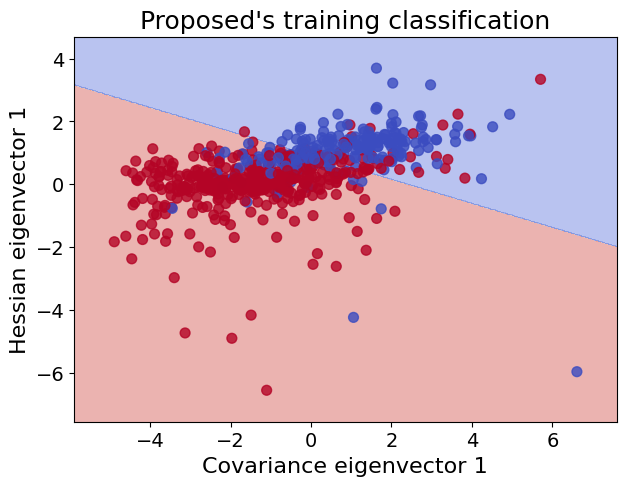

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian eigenvector 1", fontsize=16)
plt.xlabel("Covariance eigenvector 1", fontsize=16)
plt.title("Proposed's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure J</b></font>

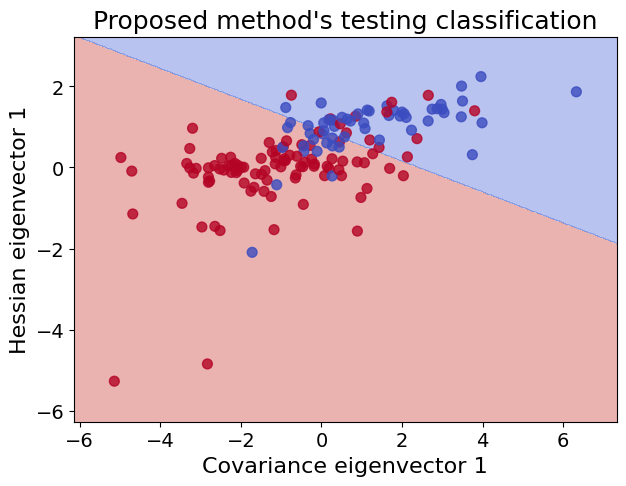

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian eigenvector 1", fontsize=16)
plt.xlabel("Covariance eigenvector 1", fontsize=16)
plt.title("Proposed method's testing classification", fontsize=18)
plt.show()

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

proposed_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[86 13]
 [17 38]]
Accuracy: 0.8051948051948052
Precision: 0.7450980392156863
Recall: 0.6909090909090909
F1 score: 0.7169811320754716
ROC AUC score: 0.7797979797979798
Cohen's kappa score: 0.568788501026694


### Hessian method

In [ ]:

# Separate features and target variable
X_train_proj = np.stack((H_train_proj[:,1], H_train_proj[:,0]), axis=1)

X_test_proj = np.stack((H_test_proj[:,1], H_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_test_pred = classifier.predict(X_test_proj)


#### <font color=#FF5F1F><b>Figure K</b></font>

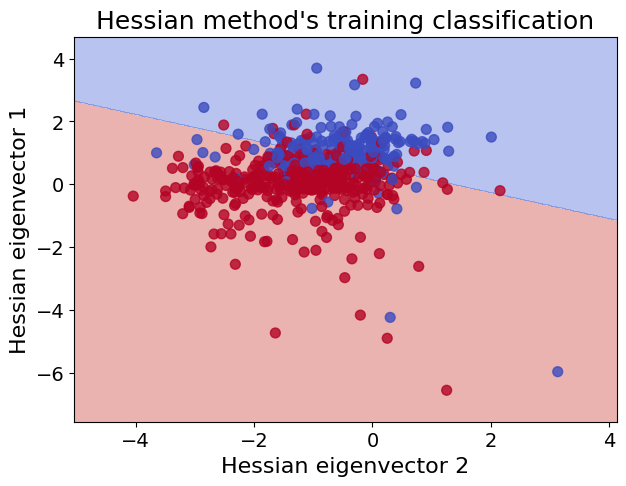

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian eigenvector 1", fontsize=16)
plt.xlabel("Hessian eigenvector 2", fontsize=16)
plt.title("Hessian method's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure L</b></font>

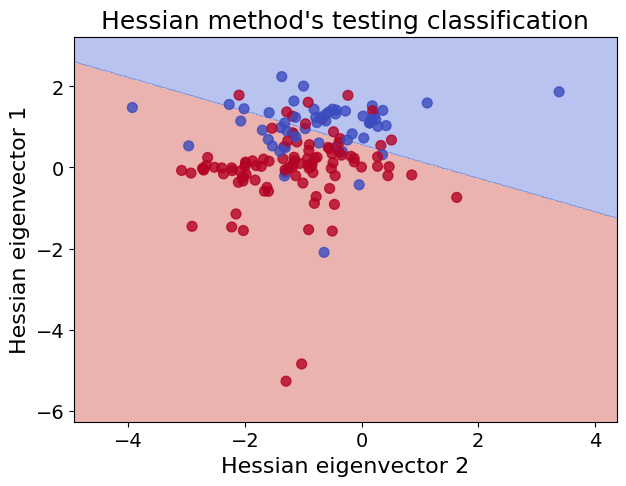

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian eigenvector 1", fontsize=16)
plt.xlabel("Hessian eigenvector 2", fontsize=16)
plt.title("Hessian method's testing classification", fontsize=18)
plt.show()

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

hessian_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[88 11]
 [21 34]]
Accuracy: 0.7922077922077922
Precision: 0.7555555555555555
Recall: 0.6181818181818182
F1 score: 0.6799999999999999
ROC AUC score: 0.7535353535353535
Cohen's kappa score: 0.5284210526315789


### PCA

In [ ]:
# Separate features and target variable
X_train_proj = np.stack((C_train_proj[:,1], C_train_proj[:,0]), axis=1)

X_test_proj = np.stack((C_test_proj[:,1], C_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_test_pred = classifier.predict(X_test_proj)


#### <font color=#FF5F1F><b>Figure M</b></font>

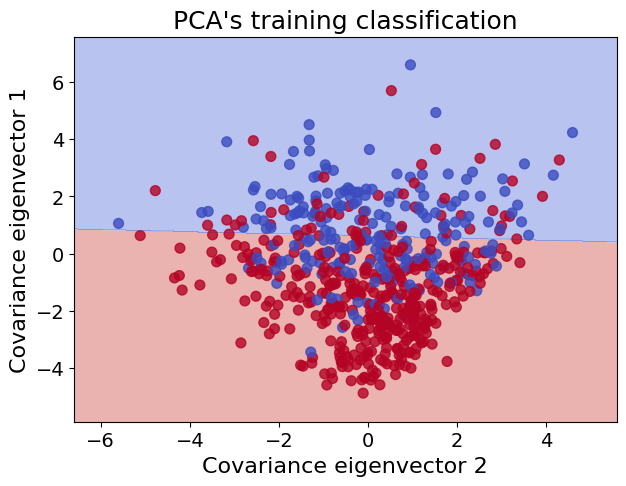

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Covariance eigenvector 1", fontsize=16)
plt.xlabel("Covariance eigenvector 2", fontsize=16)
plt.title("PCA's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure N</b></font>

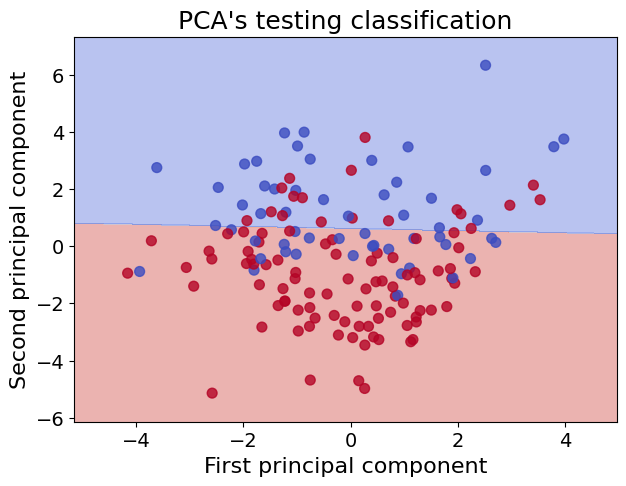

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Second principal component", fontsize=16)
plt.xlabel("First principal component", fontsize=16)
plt.title("PCA's testing classification", fontsize=18)
plt.show()

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

cov_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[81 18]
 [26 29]]
Accuracy: 0.7142857142857143
Precision: 0.6170212765957447
Recall: 0.5272727272727272
F1 score: 0.5686274509803921
ROC AUC score: 0.6727272727272727
Cohen's kappa score: 0.35699373695198333


### UMAP

In [ ]:
# Define the target variable and the features
target = train_y
features = train_X

# Create a supervised UMAP object
umap_supervised = umap.UMAP(
    n_neighbors=20, n_components=2, metric="euclidean", random_state=23
)

# Fit the UMAP model with the features and target variable
embedding = umap_supervised.fit_transform(features, y=target)

In [ ]:
# Separate features and target variable
X_train_umap = pd.DataFrame(embedding)
y_train_umap = target

X_test_umap = umap_supervised.transform(X_test)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_umap, target)

# Make predictions on the training and test sets
y_test_pred = classifier.predict(X_test_umap)

#### <font color=#FF5F1F><b>Figure O</b></font>

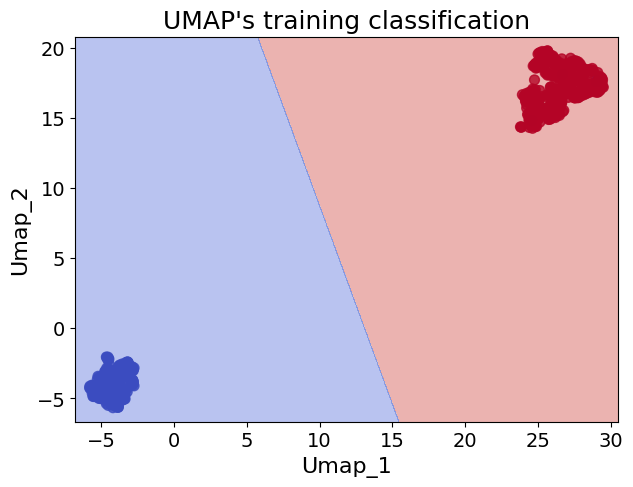

In [ ]:
X_train_proj = X_train_umap

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=y_train_umap,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.xlabel("Umap_1", fontsize=16)
plt.ylabel("Umap_2", fontsize=16)
plt.title("UMAP's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure P</b></font>

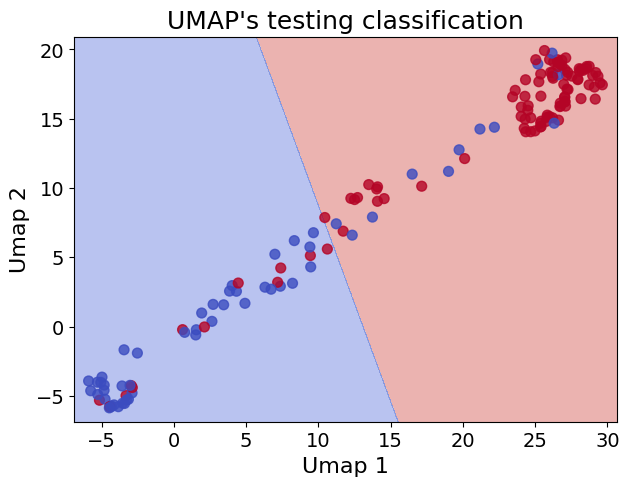

In [ ]:
X_test_proj = pd.DataFrame(X_test_umap)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
scatter = plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
    label="Test Data"  # Label for the scatter points
)
plt.xlabel("Umap 1", fontsize=16)
plt.ylabel("Umap 2", fontsize=16)
plt.title("UMAP's testing classification", fontsize=18)

plt.show()


In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

umap_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets
print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[87 12]
 [12 43]]
Accuracy: 0.8441558441558441
Precision: 0.7818181818181819
Recall: 0.7818181818181819
F1 score: 0.7818181818181819
ROC AUC score: 0.8303030303030303
Cohen's kappa score: 0.6606060606060606


### Linear discriminant analysis (LDA)

In [ ]:
# Creating an instance of the LDA class
lda = LinearDiscriminantAnalysis()

# Fitting the LDA model to the data
lda.fit(train_X, train_y)

# Transforming the data to the LDA space
X_lda = lda.transform(train_X)

In [ ]:
# Fit the SVM model to the training data
svm = SVC(kernel="linear")
svm.fit(X_lda, train_y)

# Extract hyperplane coefficients
w = svm.coef_[0]
b = svm.intercept_[0]

# Make predictions on the test data
X_lda_test = lda.transform(X_test)
y_pred = svm.predict(X_lda_test)# Create a plot of the embedding with the target variable as color

#### <font color=#FF5F1F><b>Figure Q</b></font>

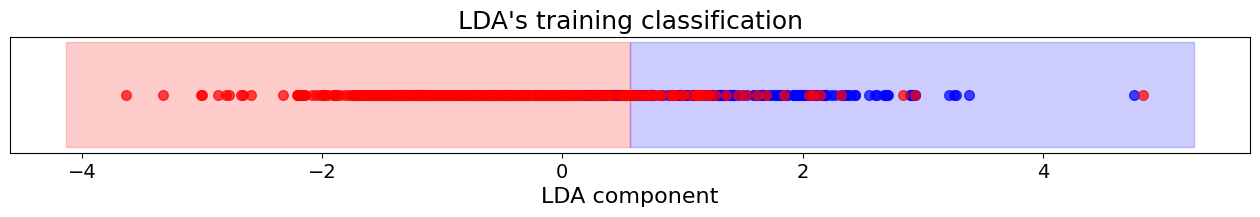

In [ ]:
# Create a plot of the embedding with the target variable as color
positive = X_lda[train_y == 1]
negative = X_lda[train_y == 0]

# Find the midpoint between the rightmost blue point and the leftmost red point
midpoint = -b / w

plt.figure(figsize=(16, 1.5))

plt.plot(
    positive[:, 0],
    np.zeros_like(positive[:, 0]),
    "bo",
    alpha=0.7,
    label="1",
    markersize=7,
)
plt.plot(
    negative[:, 0],
    np.zeros_like(negative[:, 0]),
    "ro",
    alpha=0.7,
    label="0",
    markersize=7,
)


# Shade the areas on either side of the midpoint
if np.mean(positive[:, 0]) < np.mean(negative[:, 0]):
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(positive[:, 0]) - 0.5, color="blue", alpha=0.2
  )
  plt.fill_betweenx(
      [-5, 5], np.max(negative[:, 0]) + 0.5, midpoint, color="red", alpha=0.2
  )
else:
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(negative[:, 0]) - 0.5, color="red", alpha=0.2
  )
  plt.fill_betweenx(
      [-5, 5], np.max(positive[:, 0]) + 0.5, midpoint, color="blue", alpha=0.2
  )

# Add a vertical line at the midpoint
# plt.axvline(midpoint, color='k', linestyle='--')

plt.title(f"LDA's training classification", fontsize=18)
plt.xlabel("LDA component", fontsize=16)
#plt.legend()
plt.gca().get_yaxis().set_visible(False)
plt.show()

#### <font color=#FF5F1F><b>Figure R</b></font>

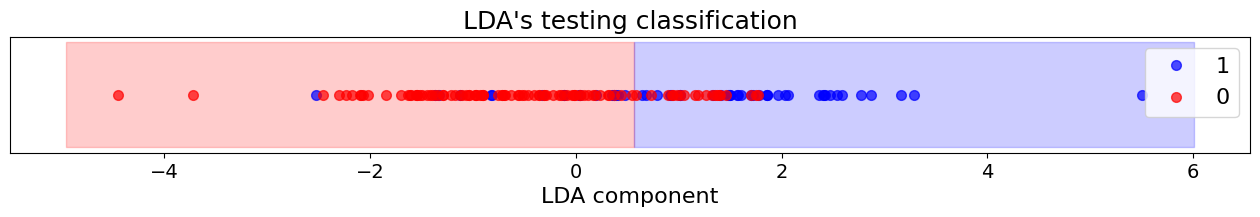

In [ ]:
# Create a plot of the embedding with the target variable as color
positive = X_lda_test[y_test == 1]
negative = X_lda_test[y_test == 0]

# Find the midpoint between the rightmost blue point and the leftmost red point
midpoint = -b / w

plt.figure(figsize=(16, 1.5))

plt.plot(
    positive[:, 0],
    np.zeros_like(positive[:, 0]),
    "bo",
    alpha=0.7,
    label="1",
    markersize=7,
)
plt.plot(
    negative[:, 0],
    np.zeros_like(negative[:, 0]),
    "ro",
    alpha=0.7,
    label="0",
    markersize=7,
)


# Shade the areas on either side of the midpoint
if np.mean(positive[:, 0]) < np.mean(negative[:, 0]):
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(positive[:, 0]) - 0.5, color="blue", alpha=0.2
  )
  plt.fill_betweenx(
      [-5, 5], np.max(negative[:, 0]) + 0.5, midpoint, color="red", alpha=0.2
  )
else:
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(negative[:, 0]) - 0.5, color="red", alpha=0.2
  )
  plt.fill_betweenx(
      [-5, 5], np.max(positive[:, 0]) + 0.5, midpoint, color="blue", alpha=0.2
  )

# Add a vertical line at the midpoint

plt.title(f"LDA's testing classification", fontsize=18)
plt.xlabel("LDA component", fontsize=16)
plt.legend(fontsize=16)
plt.gca().get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)

lda_eval = [
    precision,
    recall,
    f1,
    roc_auc,
    cohen_kappa,
]

# Print the evaluation metrics

print("Test set metrics:")
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)
print("Cohen's kappa score:", cohen_kappa)

Test set metrics:
Confusion Matrix:
 [[79 20]
 [18 37]]
Accuracy: 0.7532467532467533
Precision: 0.6491228070175439
Recall: 0.6727272727272727
F1 score: 0.6607142857142858
ROC AUC score: 0.7353535353535354
Cohen's kappa score: 0.46693386773547096


## Cross validation

### Proposed method

In [ ]:
# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []


# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Calculating the covariance matrix
    covariance_matrix = train_X.cov()
    C_eigenvalues, C_eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(C_eigenvalues)[::-1]
    C_eigenvalues_sorted = C_eigenvalues[sorted_indices]
    C_eigenvectors_sorted = C_eigenvectors[:, sorted_indices]

    # Resample the training set using RandomOverSampler to address class imbalance
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(train_X, train_y)

    # Set the random seed
    torch.manual_seed(1)

    # Create data loaders for training and test sets
    train_dataset = MyDataset(X_train, y_train)
    test_dataset = MyDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Instantiate the model and the optimizer
    model = MyModel(X_train.shape[1])
    optimizer = optim.Adam(model.parameters())

    # Train the model
    num_epochs = 100
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()

    # Set the model to evaluation mode
    model.eval()

    # Compute the average Hessian matrix
    hessian_sum = None
    for i in range(len(train_X)):
        x = torch.tensor(train_X.iloc[i].values, dtype=torch.float32)
        y = torch.tensor([train_y.iloc[i]], dtype=torch.float32)

        hessian_matrix = hessian(lambda inputs: criterion(model(inputs), y), x)

        if hessian_sum is None:
            hessian_sum = hessian_matrix
        else:
            hessian_sum += hessian_matrix

    hessian_matrix_avg = hessian_sum / len(train_X)

    H = hessian_matrix_avg.numpy()
    H_eigenvalues, H_eigenvectors = np.linalg.eig(H)
    H_eigenvectors = np.real(H_eigenvectors)
    sorted_indices = np.argsort(H_eigenvalues)[::-1]
    H_eigenvalues_sorted = H_eigenvalues[sorted_indices]
    H_eigenvectors_sorted = H_eigenvectors[:, sorted_indices]

    # Compute 24-dimensional projections using eigenvectors_sorted
    H_train_proj = np.dot(train_X, H_eigenvectors_sorted[:, :24])

    # Compute 24-dimensional projections using eigenvectors_sorted
    C_train_proj = np.dot(train_X, C_eigenvectors_sorted[:, :24])

    # Compute 24-dimensional projections using eigenvectors_sorted
    H_test_proj = np.dot(X_test, H_eigenvectors_sorted[:, :24])

    # Compute 24-dimensional projections using eigenvectors_sorted
    C_test_proj = np.dot(X_test, C_eigenvectors_sorted[:, :24])

    # Separate features and target variable
    X_train_proj = np.stack((H_train_proj[:, 0], C_train_proj[:, 0]), axis=1)

    X_test_proj = np.stack((H_test_proj[:, 0], C_test_proj[:, 0]), axis=1)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_proj, train_y)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_proj)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
proposed_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.7792207792207793, Precision=0.6785714285714286, Recall=0.7037037037037037, F1=0.6909090909090909, ROC AUC=0.7618518518518519, Cohen's Kappa=0.519280205655527
Fold 2: Accuracy=0.8441558441558441, Precision=0.7857142857142857, Recall=0.7857142857142857, F1=0.7857142857142857, ROC AUC=0.8316326530612244, Cohen's Kappa=0.6632653061224489
Fold 3: Accuracy=0.7922077922077922, Precision=0.6956521739130435, Recall=0.64, F1=0.6666666666666666, ROC AUC=0.7526923076923078, Cohen's Kappa=0.5161036920659858
Fold 4: Accuracy=0.8961038961038961, Precision=0.85, Recall=0.7727272727272727, F1=0.8095238095238095, ROC AUC=0.8590909090909091, Cohen's Kappa=0.7383177570093458
Fold 5: Accuracy=0.8311688311688312, Precision=0.8, Recall=0.7142857142857143, F1=0.7547169811320756, ROC AUC=0.806122448979592, Cohen's Kappa=0.6266318537859008
Fold 6: Accuracy=0.7532467532467533, Precision=0.8181818181818182, Recall=0.5454545454545454, F1=0.6545454545454545, ROC AUC=0.7272727272727273, Cohen's Ka

### Hessian method

In [ ]:
# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []


# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Resample the training set using RandomOverSampler to address class imbalance
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(train_X, train_y)

    # Set the random seed
    torch.manual_seed(1)

    # Create data loaders for training and test sets
    train_dataset = MyDataset(X_train, y_train)
    train_dataset = MyDataset(train_X, train_y)
    test_dataset = MyDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Instantiate the model and the optimizer
    model = MyModel(X_train.shape[1])
    optimizer = optim.Adam(model.parameters())

    # Train the model
    num_epochs = 100
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()

    # Set the model to evaluation mode
    model.eval()

    # Compute the average Hessian matrix
    hessian_sum = None
    for i in range(len(train_X)):
        x = torch.tensor(train_X.iloc[i].values, dtype=torch.float32)
        y = torch.tensor([train_y.iloc[i]], dtype=torch.float32)

        hessian_matrix = hessian(lambda inputs: criterion(model(inputs), y), x)

        if hessian_sum is None:
            hessian_sum = hessian_matrix
        else:
            hessian_sum += hessian_matrix

    hessian_matrix_avg = hessian_sum / len(train_X)

    H = hessian_matrix_avg.numpy()
    H_eigenvalues, H_eigenvectors = np.linalg.eig(H)
    H_eigenvectors = np.real(H_eigenvectors)
    sorted_indices = np.argsort(H_eigenvalues)[::-1]
    H_eigenvalues_sorted = H_eigenvalues[sorted_indices]
    H_eigenvectors_sorted = H_eigenvectors[:, sorted_indices]

    # Compute 24-dimensional projections using eigenvectors_sorted
    H_train_proj = np.dot(train_X, H_eigenvectors_sorted[:, :24])

    # Compute 24-dimensional projections using eigenvectors_sorted
    H_test_proj = np.dot(X_test, H_eigenvectors_sorted[:, :24])

    # Separate features and target variable
    X_train_proj = np.stack((H_train_proj[:, 0], H_train_proj[:, 1]), axis=1)

    X_test_proj = np.stack((H_test_proj[:, 0], H_test_proj[:, 1]), axis=1)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_proj, train_y)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_proj)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
hessian_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.7792207792207793, Precision=0.7272727272727273, Recall=0.5925925925925926, F1=0.6530612244897959, ROC AUC=0.7362962962962963, Cohen's Kappa=0.4936170212765957
Fold 2: Accuracy=0.8441558441558441, Precision=0.8333333333333334, Recall=0.7142857142857143, F1=0.7692307692307692, ROC AUC=0.8163265306122449, Cohen's Kappa=0.6526315789473685
Fold 3: Accuracy=0.7532467532467533, Precision=0.65, Recall=0.52, F1=0.5777777777777778, ROC AUC=0.6926923076923077, Cohen's Kappa=0.40649087221095337
Fold 4: Accuracy=0.8441558441558441, Precision=0.7272727272727273, Recall=0.7272727272727273, F1=0.7272727272727273, ROC AUC=0.8090909090909091, Cohen's Kappa=0.6181818181818182
Fold 5: Accuracy=0.8441558441558441, Precision=0.8333333333333334, Recall=0.7142857142857143, F1=0.7692307692307692, ROC AUC=0.8163265306122449, Cohen's Kappa=0.6526315789473685
Fold 6: Accuracy=0.7402597402597403, Precision=0.8095238095238095, Recall=0.5151515151515151, F1=0.6296296296296297, ROC AUC=0.7121212121

### PCA

In [ ]:
# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []


# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Calculating the covariance matrix
    covariance_matrix = train_X.cov()
    C_eigenvalues, C_eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(C_eigenvalues)[::-1]
    C_eigenvalues_sorted = C_eigenvalues[sorted_indices]
    C_eigenvectors_sorted = C_eigenvectors[:, sorted_indices]

    # Compute 24-dimensional projections using eigenvectors_sorted
    C_train_proj = np.dot(train_X, C_eigenvectors_sorted[:, :24])

    # Compute 24-dimensional projections using eigenvectors_sorted
    C_test_proj = np.dot(X_test, C_eigenvectors_sorted[:, :24])

    # Separate features and target variable
    X_train_proj = np.stack((C_train_proj[:, 0], C_train_proj[:, 1]), axis=1)

    X_test_proj = np.stack((C_test_proj[:, 0], C_test_proj[:, 1]), axis=1)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_proj, train_y)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_proj)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
cov_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.7272727272727273, Precision=0.6363636363636364, Recall=0.5185185185185185, F1=0.5714285714285714, ROC AUC=0.6792592592592592, Cohen's Kappa=0.37446808510638296
Fold 2: Accuracy=0.7012987012987013, Precision=0.6, Recall=0.5357142857142857, F1=0.5660377358490566, ROC AUC=0.6658163265306122, Cohen's Kappa=0.33942558746736295
Fold 3: Accuracy=0.7532467532467533, Precision=0.65, Recall=0.52, F1=0.5777777777777778, ROC AUC=0.6926923076923077, Cohen's Kappa=0.40649087221095337
Fold 4: Accuracy=0.7532467532467533, Precision=0.5882352941176471, Recall=0.45454545454545453, F1=0.5128205128205129, ROC AUC=0.6636363636363637, Cohen's Kappa=0.35121951219512193
Fold 5: Accuracy=0.8051948051948052, Precision=0.782608695652174, Recall=0.6428571428571429, F1=0.7058823529411765, ROC AUC=0.770408163265306, Cohen's Kappa=0.5623342175066313
Fold 6: Accuracy=0.6883116883116883, Precision=0.7368421052631579, Recall=0.42424242424242425, F1=0.5384615384615385, ROC AUC=0.6553030303030304, Cohe

### UMAP

In [ ]:
# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []


# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a supervised UMAP object
    umap_supervised = umap.UMAP(
        n_neighbors=20, n_components=2, metric="euclidean", random_state=23
    )

    # Fit the UMAP model with the features and target variable
    embedding = umap_supervised.fit_transform(features, y=target)

    # Separate features and target variable
    X_train_umap = pd.DataFrame(embedding)
    y_train_umap = target

    X_test_umap = umap_supervised.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_umap, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_umap)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
umap_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.8181818181818182, Precision=0.7096774193548387, Recall=0.8148148148148148, F1=0.7586206896551724, ROC AUC=0.8174074074074075, Cohen's Kappa=0.6138968481375359
Fold 2: Accuracy=0.8701298701298701, Precision=0.8461538461538461, Recall=0.7857142857142857, F1=0.8148148148148148, ROC AUC=0.8520408163265305, Cohen's Kappa=0.7150259067357514
Fold 3: Accuracy=0.7142857142857143, Precision=0.56, Recall=0.56, F1=0.56, ROC AUC=0.6742307692307692, Cohen's Kappa=0.3484615384615385
Fold 4: Accuracy=0.8701298701298701, Precision=0.75, Recall=0.8181818181818182, F1=0.7826086956521738, ROC AUC=0.8545454545454546, Cohen's Kappa=0.6902654867256637
Fold 5: Accuracy=0.8571428571428571, Precision=0.84, Recall=0.75, F1=0.7924528301886793, ROC AUC=0.8341836734693878, Cohen's Kappa=0.6840731070496084
Fold 6: Accuracy=0.7532467532467533, Precision=0.8181818181818182, Recall=0.5454545454545454, F1=0.6545454545454545, ROC AUC=0.7272727272727273, Cohen's Kappa=0.47430830039525695
Fold 7: Accurac

### LDA

In [ ]:
# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Creating an instance of the LDA class
    lda = LinearDiscriminantAnalysis()

    # Fitting the LDA model to the data
    lda.fit(train_X, train_y)

    # Transforming the data to the LDA space
    X_lda = lda.transform(train_X)

    # Fit the SVM model to the training data
    svm = SVC(kernel="linear")
    svm.fit(X_lda, train_y)

    # Make predictions on the test data
    X_lda_test = lda.transform(X_test)
    y_test_pred = svm.predict(X_lda_test)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
lda_values = [np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(roc_auc_scores), np.mean(kappa_scores)]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)


Fold 1: Accuracy=0.7402597402597403, Precision=0.6296296296296297, Recall=0.6296296296296297, F1=0.6296296296296297, ROC AUC=0.7148148148148149, Cohen's Kappa=0.4296296296296296
Fold 2: Accuracy=0.7662337662337663, Precision=0.6785714285714286, Recall=0.6785714285714286, F1=0.6785714285714286, ROC AUC=0.7474489795918368, Cohen's Kappa=0.4948979591836734
Fold 3: Accuracy=0.7922077922077922, Precision=0.6956521739130435, Recall=0.64, F1=0.6666666666666666, ROC AUC=0.7526923076923078, Cohen's Kappa=0.5161036920659858
Fold 4: Accuracy=0.8701298701298701, Precision=0.8, Recall=0.7272727272727273, F1=0.761904761904762, ROC AUC=0.8272727272727273, Cohen's Kappa=0.6728971962616822
Fold 5: Accuracy=0.8571428571428571, Precision=0.84, Recall=0.75, F1=0.7924528301886793, ROC AUC=0.8341836734693878, Cohen's Kappa=0.6840731070496084
Fold 6: Accuracy=0.7142857142857143, Precision=0.7619047619047619, Recall=0.48484848484848486, F1=0.5925925925925926, ROC AUC=0.6856060606060606, Cohen's Kappa=0.388888

### Kernel PCA with linear kernel

In [ ]:
X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a kernel PCA object with the best parameters
    kpca = KernelPCA(kernel='linear', n_components=2)

    # Fit the kernel PCA model with the features
    X_train_kpca = kpca.fit_transform(features)

    # Separate features and target variable
    y_train_kpca = target

    # Transform the test set using the kernel PCA model
    X_test_kpca = kpca.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_kpca, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_kpca)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
pca_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.7272727272727273, Precision=0.6363636363636364, Recall=0.5185185185185185, F1=0.5714285714285714, ROC AUC=0.6792592592592592, Cohen's Kappa=0.37446808510638296
Fold 2: Accuracy=0.7012987012987013, Precision=0.6, Recall=0.5357142857142857, F1=0.5660377358490566, ROC AUC=0.6658163265306122, Cohen's Kappa=0.33942558746736295
Fold 3: Accuracy=0.7532467532467533, Precision=0.65, Recall=0.52, F1=0.5777777777777778, ROC AUC=0.6926923076923077, Cohen's Kappa=0.40649087221095337
Fold 4: Accuracy=0.7532467532467533, Precision=0.5882352941176471, Recall=0.45454545454545453, F1=0.5128205128205129, ROC AUC=0.6636363636363637, Cohen's Kappa=0.35121951219512193
Fold 5: Accuracy=0.8051948051948052, Precision=0.782608695652174, Recall=0.6428571428571429, F1=0.7058823529411765, ROC AUC=0.770408163265306, Cohen's Kappa=0.5623342175066313
Fold 6: Accuracy=0.6883116883116883, Precision=0.7368421052631579, Recall=0.42424242424242425, F1=0.5384615384615385, ROC AUC=0.6553030303030304, Cohe

### Kernel PCA

In [ ]:
# Define the dataset_df, assuming it's already loaded

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Define the parameter grid for KDA
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],
    'gamma': [0.01, 0.1, 1, 10],
    'degree': [2, 3, 4]
}



# Use KFold for cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store the best parameters and corresponding score
best_params = None
best_score = 0.0  # Assuming higher F1 score is better

print("Best parameter search:\n")

# Iterate through parameter combinations
for kernel in param_grid['kernel']:
    for gamma in param_grid['gamma']:
        for degree in param_grid['degree']:
            # Initialize KDA with current parameters
            kpca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma, degree=degree)

            # Perform cross-validation
            scores = []

            for train_index, test_index in kf.split(X_df):
                X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
                y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

                # Define the target variable and the features
                target = y_train
                features = X_train

                # Fit the kernel PCA model with the features
                X_train_kpca = kpca.fit_transform(features)

                # Transform the test set using the kernel PCA model
                X_test_kpca = kpca.transform(X_test)

                # Initialize the LinearSVC classifier
                classifier = LinearSVC(random_state=1)

                # Train the classifier on the training set
                classifier.fit(X_train_kpca, target)

                # Make predictions on the training and test sets
                y_test_pred = classifier.predict(X_test_kpca)

                # Calculate F1 score and store
                score = f1_score(y_test, y_test_pred)
                scores.append(score)

            # Calculate average F1 score across folds
            avg_score = np.mean(scores)

            # Update best parameters if current combination is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'kernel': kernel, 'gamma': gamma, 'degree': degree}
                print(f"Best parameters: {best_params}")
                print(f"Best F1 score: {best_score} \n")

# Print the best parameters and corresponding score
print(f"Final best parameters: {best_params}")
print(f"Final best F1 score: {best_score}")

Best parameter search:

Best parameters: {'kernel': 'linear', 'gamma': 0.01, 'degree': 2}
Best F1 score: 0.582285706805548 

Best parameters: {'kernel': 'poly', 'gamma': 0.01, 'degree': 4}
Best F1 score: 0.5862961494089314 

Best parameters: {'kernel': 'poly', 'gamma': 0.1, 'degree': 2}
Best F1 score: 0.6050773991603411 

Best parameters: {'kernel': 'cosine', 'gamma': 0.01, 'degree': 2}
Best F1 score: 0.6185500459777222 

Final best parameters: {'kernel': 'cosine', 'gamma': 0.01, 'degree': 2}
Final best F1 score: 0.6185500459777222


In [ ]:
X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a kernel PCA object with the best parameters
    kpca = KernelPCA(n_components=2, **best_params)

    # Fit the kernel PCA model with the features
    X_train_kpca = kpca.fit_transform(features)

    # Separate features and target variable
    y_train_kpca = target

    # Transform the test set using the kernel PCA model
    X_test_kpca = kpca.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_kpca, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_kpca)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
kpca_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.7272727272727273, Precision=0.625, Recall=0.5555555555555556, F1=0.5882352941176471, ROC AUC=0.6877777777777779, Cohen's Kappa=0.38540478905359177
Fold 2: Accuracy=0.7012987012987013, Precision=0.5862068965517241, Recall=0.6071428571428571, F1=0.5964912280701754, ROC AUC=0.6811224489795917, Cohen's Kappa=0.35949367088607587
Fold 3: Accuracy=0.7272727272727273, Precision=0.6, Recall=0.48, F1=0.5333333333333332, ROC AUC=0.6630769230769231, Cohen's Kappa=0.3440162271805274
Fold 4: Accuracy=0.7922077922077922, Precision=0.6363636363636364, Recall=0.6363636363636364, F1=0.6363636363636364, ROC AUC=0.7454545454545454, Cohen's Kappa=0.49090909090909085
Fold 5: Accuracy=0.8311688311688312, Precision=0.8, Recall=0.7142857142857143, F1=0.7547169811320756, ROC AUC=0.806122448979592, Cohen's Kappa=0.6266318537859008
Fold 6: Accuracy=0.6623376623376623, Precision=0.6666666666666666, Recall=0.42424242424242425, F1=0.5185185185185185, ROC AUC=0.6325757575757576, Cohen's Kappa=0.277

### Kernel DA with linear kernel

In [ ]:
# Define the dataset_df, assuming it's already loaded

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)


# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a kernel PCA object with the best parameters
    klda = KDA(n_components=2, kernel='linear')

    # Fit the kernel PCA model with the features
    X_train_klda = klda.fit_transform(features, target)

    # Transform the test set using the kernel PCA model
    X_test_klda = klda.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_klda, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_klda)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
llda_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.7662337662337663, Precision=0.6363636363636364, Recall=0.7777777777777778, F1=0.7000000000000001, ROC AUC=0.768888888888889, Cohen's Kappa=0.5116279069767442
Fold 2: Accuracy=0.2727272727272727, Precision=0.03333333333333333, Recall=0.03571428571428571, F1=0.03448275862068965, ROC AUC=0.2219387755102041, Cohen's Kappa=-0.5477386934673367
Fold 3: Accuracy=0.7532467532467533, Precision=0.625, Recall=0.6, F1=0.6122448979591836, ROC AUC=0.7134615384615385, Cohen's Kappa=0.43140303148076165
Fold 4: Accuracy=0.37662337662337664, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.26363636363636367, Cohen's Kappa=-0.4482758620689653
Fold 5: Accuracy=0.8311688311688312, Precision=0.7586206896551724, Recall=0.7857142857142857, F1=0.7719298245614034, ROC AUC=0.8214285714285714, Cohen's Kappa=0.6379746835443038
Fold 6: Accuracy=0.7012987012987013, Precision=0.75, Recall=0.45454545454545453, F1=0.5660377358490566, ROC AUC=0.6704545454545454, Cohen's Kappa=0.35856573705179273
Fold 7: Ac

### Kernel DA

In [ ]:
# Define the dataset_df, assuming it's already loaded

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Define the parameter grid for KDA
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],
    'gamma': [0.01, 0.1, 1, 10],
    'degree': [2, 3, 4]
}



# Use KFold for cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store the best parameters and corresponding score
best_params = None
best_score = 0.0  # Assuming higher F1 score is better

print("Best parameter search:\n")

# Iterate through parameter combinations
for kernel in param_grid['kernel']:
    for gamma in param_grid['gamma']:
        for degree in param_grid['degree']:
            # Initialize KDA with current parameters
            klda = KDA(n_components=1, kernel=kernel, gamma=gamma, degree=degree)

            # Perform cross-validation
            scores = []

            for train_index, test_index in kf.split(X_df):
                X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
                y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

                # Define the target variable and the features
                target = y_train
                features = X_train

                # Fit the kernel PCA model with the features
                X_train_klda = klda.fit_transform(features, target)

                # Transform the test set using the kernel PCA model
                X_test_klda = klda.transform(X_test)

                # Initialize the LinearSVC classifier
                classifier = LinearSVC(random_state=1)

                # Train the classifier on the training set
                classifier.fit(X_train_klda, target)

                # Make predictions on the training and test sets
                y_test_pred = classifier.predict(X_test_klda)

                # Calculate F1 score and store
                score = f1_score(y_test, y_test_pred)
                scores.append(score)

            # Calculate average F1 score across folds
            avg_score = np.mean(scores)

            # Update best parameters if current combination is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'kernel': kernel, 'gamma': gamma, 'degree': degree}
                print(f"Best parameters: {best_params}")
                print(f"Best F1 score: {best_score} \n")

# Print the best parameters and corresponding score
print(f"Final best parameters: {best_params}")
print(f"Final best F1 score: {best_score}")


Best parameter search:

Best parameters: {'kernel': 'linear', 'gamma': 0.01, 'degree': 2}
Best F1 score: 0.4857855341259648 

Best parameters: {'kernel': 'poly', 'gamma': 0.01, 'degree': 2}
Best F1 score: 0.5980110138377601 

Best parameters: {'kernel': 'poly', 'gamma': 0.01, 'degree': 3}
Best F1 score: 0.5993986179080655 

Best parameters: {'kernel': 'poly', 'gamma': 0.1, 'degree': 2}
Best F1 score: 0.6155205448146626 

Best parameters: {'kernel': 'sigmoid', 'gamma': 1, 'degree': 2}
Best F1 score: 0.6257542378011196 

Best parameters: {'kernel': 'sigmoid', 'gamma': 10, 'degree': 2}
Best F1 score: 0.6408736118828997 

Best parameters: {'kernel': 'cosine', 'gamma': 0.01, 'degree': 2}
Best F1 score: 0.6477827297618755 

Final best parameters: {'kernel': 'cosine', 'gamma': 0.01, 'degree': 2}
Final best F1 score: 0.6477827297618755


In [ ]:
# Define the dataset_df, assuming it's already loaded

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)


# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a kernel PCA object with the best parameters
    klda = KDA(n_components=1, **best_params)

    # Fit the kernel PCA model with the features
    X_train_klda = klda.fit_transform(features, target)

    # Transform the test set using the kernel PCA model
    X_test_klda = klda.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_klda, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_klda)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
klda_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)


Fold 1: Accuracy=0.7272727272727273, Precision=0.625, Recall=0.5555555555555556, F1=0.5882352941176471, ROC AUC=0.6877777777777779, Cohen's Kappa=0.38540478905359177
Fold 2: Accuracy=0.7922077922077922, Precision=0.7, Recall=0.75, F1=0.7241379310344827, ROC AUC=0.7831632653061225, Cohen's Kappa=0.5577889447236181
Fold 3: Accuracy=0.7272727272727273, Precision=0.5909090909090909, Recall=0.52, F1=0.5531914893617023, ROC AUC=0.6734615384615384, Cohen's Kappa=0.3580786026200874
Fold 4: Accuracy=0.7922077922077922, Precision=0.6363636363636364, Recall=0.6363636363636364, F1=0.6363636363636364, ROC AUC=0.7454545454545454, Cohen's Kappa=0.49090909090909085
Fold 5: Accuracy=0.8311688311688312, Precision=0.8, Recall=0.7142857142857143, F1=0.7547169811320756, ROC AUC=0.806122448979592, Cohen's Kappa=0.6266318537859008
Fold 6: Accuracy=0.6753246753246753, Precision=0.6666666666666666, Recall=0.48484848484848486, F1=0.5614035087719298, ROC AUC=0.6515151515151515, Cohen's Kappa=0.3137254901960784
F

In [ ]:
# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a Locally Linear Embedding object
    lle = LocallyLinearEmbedding(n_components=2, random_state=0)

    # Fit the LLE model with the features
    embedding = lle.fit_transform(features)

    # Separate features and target variable
    X_train_lle = pd.DataFrame(embedding)
    y_train_lle = target

    X_test_lle = lle.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_lle, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_lle)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
lle_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)


Fold 1: Accuracy=0.6493506493506493, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 2: Accuracy=0.6753246753246753, Precision=1.0, Recall=0.10714285714285714, F1=0.19354838709677416, ROC AUC=0.5535714285714286, Cohen's Kappa=0.13249211356466883
Fold 3: Accuracy=0.6753246753246753, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 4: Accuracy=0.7142857142857143, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 5: Accuracy=0.6363636363636364, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 6: Accuracy=0.5714285714285714, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 7: Accuracy=0.6493506493506493, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 8: Accuracy=0.7532467532467533, Precision=1.0, Recall=0.05, F1=0.09523809523809523, ROC AUC=0.525, Cohen's Kappa=0.07228915662650615
Fold 9: Accuracy=0.5789473684210527, Precision=0.0, Recall=0.0, F1=0.0, ROC AU

### Linear Optimal Low-rank projection (LOL)

In [ ]:
# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Creating an instance of the LOL class
    lol = LOL(n_components=2, svd_solver='full')

    # Fitting the LOL model to the data
    lol.fit(train_X, train_y)

    # Transforming the data to the LOL space
    X_lol = lol.transform(train_X)

    # Fit the SVM model to the training data
    svm = SVC(kernel="linear")
    svm.fit(X_lol, train_y)

    # Make predictions on the test data
    X_lol_test = lol.transform(X_test)
    y_test_pred = svm.predict(X_lol_test)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
lol_values = [np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(roc_auc_scores), np.mean(kappa_scores)]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.7532467532467533, Precision=0.6538461538461539, Recall=0.6296296296296297, F1=0.6415094339622641, ROC AUC=0.7248148148148149, Cohen's Kappa=0.4534927157265596
Fold 2: Accuracy=0.8051948051948052, Precision=0.7241379310344828, Recall=0.75, F1=0.736842105263158, ROC AUC=0.7933673469387755, Cohen's Kappa=0.5822784810126582
Fold 3: Accuracy=0.7272727272727273, Precision=0.6, Recall=0.48, F1=0.5333333333333332, ROC AUC=0.6630769230769231, Cohen's Kappa=0.3440162271805274
Fold 4: Accuracy=0.8311688311688312, Precision=0.7368421052631579, Recall=0.6363636363636364, F1=0.6829268292682926, ROC AUC=0.7727272727272727, Cohen's Kappa=0.5687203791469195
Fold 5: Accuracy=0.8181818181818182, Precision=0.7916666666666666, Recall=0.6785714285714286, F1=0.7307692307692307, ROC AUC=0.7882653061224489, Cohen's Kappa=0.5947368421052632
Fold 6: Accuracy=0.7142857142857143, Precision=0.7894736842105263, Recall=0.45454545454545453, F1=0.5769230769230769, ROC AUC=0.6818181818181819, Cohen's 

### t-SNE

In [ ]:
# Define the number of folds
k = 10

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("Outcome", axis=1)
y_df = dataset_df["Outcome"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a t-SNE object
    tsne = TSNE(n_components=2, random_state=0)

    # Fit the t-SNE model with the features
    embedding = tsne.fit_transform(features)

    # Separate features and target variable
    X_train_tsne = pd.DataFrame(embedding)
    y_train_tsne = target

    X_test_tsne = tsne.fit_transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_tsne, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_tsne)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
tsne_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)


Fold 1: Accuracy=0.6493506493506493, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 2: Accuracy=0.5454545454545454, Precision=0.3793103448275862, Recall=0.39285714285714285, F1=0.3859649122807017, ROC AUC=0.5127551020408163, Cohen's Kappa=0.025316455696202445
Fold 3: Accuracy=0.6753246753246753, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 4: Accuracy=0.7142857142857143, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 5: Accuracy=0.6363636363636364, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 6: Accuracy=0.5714285714285714, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 7: Accuracy=0.6493506493506493, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 8: Accuracy=0.7402597402597403, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 9: Accuracy=0.5921052631578947, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa

### Evaluation comparison

#### <font color=#FF5F1F><b>Figure S</b></font>

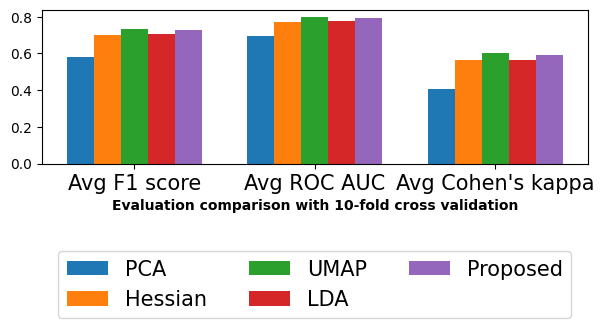

In [ ]:
# Define the evaluation metrics and their values for each method
metrics = [
    "Avg F1 score",
    "Avg ROC AUC",
    "Avg Cohen's kappa",
]

# Set the positions and width of the bars
pos = np.arange(len(metrics))
width = 0.15

# Plot the bars for each method and evaluation metric
fig, ax = plt.subplots(figsize=(6.25, 4.25))  # Adjust the figure width as needed
plt.bar(pos - 2 * width, cov_values[2:], width, label="PCA")
plt.bar(pos - width, hessian_values[2:], width, label="Hessian")
plt.bar(pos, umap_values[2:], width, label="UMAP")
plt.bar(pos + width, lda_values[2:], width, label="LDA")
plt.bar(pos + 2 * width, proposed_values[2:], width, label="Proposed")


# plt.ylabel("Values", fontweight="bold")
plt.xticks(pos, metrics, fontsize=15)

# Add xticks on the middle of the group bars
plt.xlabel(
    "Evaluation comparison with 10-fold cross validation", fontweight="bold"
)

# Move the legend to the bottom and display in a single line
plt.legend(bbox_to_anchor=(0.5, -0.5), loc="upper center", ncol=3, fontsize=15)

plt.tight_layout()  # Adjust the layout to avoid overlapping elements
plt.show()

#### <font color=#FF5F1F><b>Figure T</b></font>

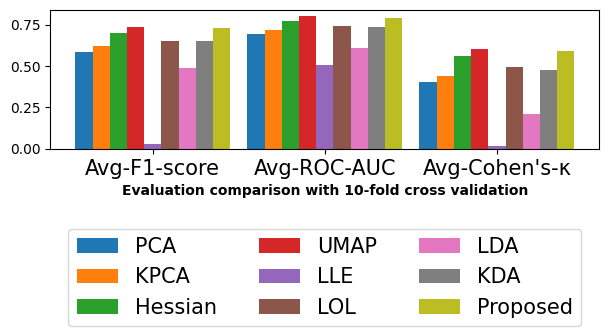

In [ ]:
# Define the evaluation metrics and their values for each method
metrics = [
    "Avg-F1-score",
    "Avg-ROC-AUC",
    "Avg-Cohen's-κ",
]

# Set the positions and width of the bars
pos = np.arange(len(metrics))
width = 0.1

# Plot the bars for each method and evaluation metric
fig, ax = plt.subplots(figsize=(6.25, 4.5))  # Adjust the figure width as needed
plt.bar(pos - 4 * width, pca_values[2:], width, label="PCA")
plt.bar(pos - 3 * width, kpca_values[2:], width, label="KPCA")
plt.bar(pos - 2 * width, hessian_values[2:], width, label="Hessian")
plt.bar(pos - 1 * width, umap_values[2:], width, label="UMAP")
plt.bar(pos, lle_values[2:], width, label="LLE")
plt.bar(pos + 1 * width, lol_values[2:], width, label="LOL")
plt.bar(pos + 2 * width, llda_values[2:], width, label="LDA")
plt.bar(pos + 3 * width, klda_values[2:], width, label="KDA")
plt.bar(pos + 4 * width, proposed_values[2:], width, label="Proposed")


# plt.ylabel("Values", fontweight="bold")
plt.xticks(pos, metrics, fontsize=15)

# Add xticks on the middle of the group bars
plt.xlabel(
    "Evaluation comparison with 10-fold cross validation", fontweight="bold"
)

# Move the legend to the bottom and display in a single line
plt.legend(bbox_to_anchor=(0.5, -0.5), loc="upper center", ncol=3, fontsize=15)

plt.tight_layout()  # Adjust the layout to avoid overlapping elements
plt.show()